# Run PESTPP-OPT

In this notebook we will setup and solve a mgmt optimization problem around how much groundwater can be pumped while maintaining sw-gw exchange

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size']=12
import flopy
import pyemu
%matplotlib inline

flopy is installed in /Users/jeremyw/Dev/gw1876/activities_csiro/notebooks/flopy


## SUPER IMPORTANT: SET HOW MANY PARALLEL WORKERS TO USE

In [2]:
num_workers = 20

In [3]:
t_d = "template"
m_d = "master_opt"

### We can look at the summary information about the parameters

In [4]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
pst.write_par_summary_table(filename="none").sort_index()

,type,transform,count,initial value,upper bound,lower bound,standard deviation
cn_hk6,cn_hk6,log,1,0,1,-1,0.5
cn_hk7,cn_hk7,log,1,0,1,-1,0.5
cn_hk8,cn_hk8,log,1,0,1,-1,0.5
cn_prsity6,cn_prsity6,log,1,0,0.176091,-0.30103,0.11928
cn_prsity7,cn_prsity7,log,1,0,0.176091,-0.30103,0.11928
cn_prsity8,cn_prsity8,log,1,0,0.176091,-0.30103,0.11928
cn_rech4,cn_rech4,log,1,0,0.0413927,-0.0457575,0.0217875
cn_rech5,cn_rech5,log,1,0,0.0413927,-0.0457575,0.0217875
cn_ss6,cn_ss6,log,1,0,1,-1,0.5
cn_ss7,cn_ss7,log,1,0,1,-1,0.5


### define our decision varible group and also set some `++args`.

Conceptually, we are going to optimize current pumping rates to make sure we meet ecological flows under both historic (current) conditions and scenario (future) conditions.  Remember the scenario is an extreme 1-year drought so if we pump too much now, the system will be too low to provide critical flows if next year is an extreme drough - transient memory!

Define a parameter group as the devision variables (e.g. the variables that we will tune to meet the optimal condition). We will define `wellflux_k02` as the decision variable group (defined by the `++arg` called `opt_dec_var_groups`. Note in the table above this represents 6 wells in the future.

We can also define which direction we want the optimization to go using `opt_direction` as `max`. This means the objective of the optimization will be to maximize future pumping subject to the constraints we will establish below.



In [5]:
pst.pestpp_options = {}
#dvg = ["welflux_k02","welflux"]
dvg = ["welflux_k02"]
pst.pestpp_options["opt_dec_var_groups"] = dvg
pst.pestpp_options["opt_direction"] = "max"

For the first run, we won't use chance constraints, so just fix all non-decision-variable parameter.  We also need to set some realistic bounds on the `welflux` multiplier decision variables.  Finally, we need to specify a larger derivative increment for the decision varible group. For typical parameter estimation, `derinc=0.01` is often sufficient for calculating a Jacobian matrix. But, for the response matrix method of optimization, the response can be subtle requiring a greater perturbation increment. We will set it to `0.25` using some `pandas` manipulation.

In [6]:
par = pst.parameter_data
par.loc[:,"partrans"] = "fixed"

#turn off pumping in the scenario
par.loc["welflux_001","parlbnd"] = 0.0 
par.loc["welflux_001","parval1"] = 0.0 
dvg_pars = par.loc[par.pargp.apply(lambda x: x in dvg),"parnme"]
par.loc[dvg_pars,"partrans"] = "none"
par.loc[dvg_pars,"parlbnd"] = 0.0
par.loc[dvg_pars,"parubnd"] = 3.0
par.loc[dvg_pars,"parval1"] = 1.0

pst.rectify_pgroups()
pst.parameter_groups.loc[dvg,"inctyp"] = "absolute"
pst.parameter_groups.loc[dvg,"inctyp"] = "absolute"
pst.parameter_groups.loc[dvg,"derinc"] = 0.25

pst.parameter_groups.loc[dvg,:]

,pargpnme,inctyp,derinc,derinclb,forcen,derincmul,dermthd,splitthresh,splitreldiff,splitaction,extra
pargpnme,,,,,,,,,,,
welflux_k02,welflux_k02,absolute,0.25,0.0,switch,2.0,parabolic,0.00001,0.5,smaller,NaN


### define constraints

model-based and prior information constraints are identified in `pestpp-opt` by an obs group that starts with "less_than" or "greater_than" and a weight greater than zero.  So first, we turn off all of the weights and get names for the sw-gw exchange forecasts (funny how optimization turns forecasts into constraints...)

In [7]:
obs = pst.observation_data
obs.loc[:,"weight"] = 0.0
swgw_const = obs.loc[obs.obsnme.apply(lambda x: "fa" in x and( "hw" in x or "tw" in x)),"obsnme"]
obs.loc[swgw_const,:]

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
fa_hw_19791230,fa_hw_19791230,-226.815090,0.0,flaqx,NaN
fa_hw_19801229,fa_hw_19801229,28.774520,0.0,flaqx,NaN
fa_tw_19791230,fa_tw_19791230,-436.949268,0.0,flaqx,NaN
fa_tw_19801229,fa_tw_19801229,-253.593190,0.0,flaqx,NaN


We need to change the obs group (`obgnme`) so that `pestpp-opt` will recognize these two model outputs as constraints.  The `obsval` becomes the RHS of the constraint.  We also need to set a lower bound constraint on the total abstraction rate (good thing we included all those list file budget components as observations!)

In [8]:
obs.loc[swgw_const,"obgnme"] = "less_than"
obs.loc[swgw_const,"weight"] = 1.0

# we must have at least 300 m3/day of flux from gw to sw
# for historic and scenario periods
# and for both headwaters and tailwaters
obs.loc[swgw_const,"obsval"] = -300

# tot_abs_rate = ["flx_wells_19791230"]#,"flx_wells_19801229"]
# obs.loc[tot_abs_rate,"obgnme"] = "less_than"
# obs.loc[tot_abs_rate,"weight"] = 1.0
# obs.loc[tot_abs_rate,"obsval"] = -900.0
# pst.less_than_obs_constraints

Now we need to define a minimum total pumping rate, otherwise this opt problem might yield a solution that doesn't give enough water for the intended usage.  We will do this through a prior information constraint since this just a sum of decision varible values - the required minimum value will the sum of current pumping rates:

In [9]:
pyemu.pst_utils.pst_config["prior_fieldnames"]

['pilbl', 'equation', 'weight', 'obgnme']

Since all pumping wells are using the same rate, we can just use a `1.0` multiplier in front of each `wel.flux` decision varialbe.  If that is not the case, then you need to set the multipliers to be more meaningful

In [10]:
pi = pst.null_prior
pi.loc["pi_1","obgnme"] = "greater_than"
pi.loc["pi_1","pilbl"] = "pi_1"
pi.loc["pi_1","equation"] = " + ".join(["1.0 * {0}".format(d) for d in dvg_pars]) +\
                            " = {0}".format(par.loc[dvg_pars,"parval1"].sum())
pi.loc["pi_1","weight"] = 1.0
pi.equation["pi_1"]

'1.0 * wf0200090016 + 1.0 * wf0200110013 + 1.0 * wf0200200014 + 1.0 * wf0200260010 + 1.0 * wf0200290006 + 1.0 * wf0200340012 = 6.0'

In [11]:
pst.prior_information

,obgnme,pilbl,equation,weight
pi_1,greater_than,pi_1,1.0 * wf0200090016 + 1.0 * wf0200110013 + 1.0 * wf0200200014 + 1.0 * wf0200260010 + 1.0 * wf0200...,1.0


#### Note that setting `noptmax=1` is equivalent to selecting Linear Programming (LP) as the optimization algorithm (thus assuming a linear response matrix).

#### A higher value of `noptmax` runs Sequential Linear Programming (SLP)

In [12]:
pst.control_data.noptmax = 1
pst.write(os.path.join(t_d,"freyberg_opt.pst"))
pyemu.os_utils.start_slaves(t_d,"pestpp-opt","freyberg_opt.pst",num_slaves=num_workers,master_dir=m_d)

noptmax:1, npar_adj:6, nnz_obs:4


Let's load and inspect the response matrix

In [13]:
jco = pyemu.Jco.from_binary(os.path.join(m_d,"freyberg_opt.1.jcb")).to_dataframe().loc[pst.less_than_obs_constraints,:]
jco

,wf0200090016,wf0200110013,wf0200200014,wf0200260010,wf0200290006,wf0200340012
fa_hw_19791230,137.57200,126.32400,46.30000,21.9080,18.12000,4.8320
fa_hw_19801229,22.66400,28.77600,12.08000,12.3920,13.28800,3.4040
fa_tw_19791230,6.50728,14.53516,93.28136,92.4232,71.84608,82.9612
fa_tw_19801229,4.11600,7.64240,15.33680,31.0356,35.01240,17.5824


We see the transient effects in the nonzero value between current pumping rates (columns) and scenario sw-gw exchange (rows from 1980)

Let's also load the optimal decision variable values:

In [14]:
par_df = pyemu.pst_utils.read_parfile(os.path.join(m_d,"freyberg_opt.1.par"))
print(par_df.loc[dvg_pars,"parval1"].sum())
par_df.loc[dvg_pars,:]

11.843760938848522


,parnme,parval1,scale,offset
parnme,,,,
wf0200090016,wf0200090016,3.000000,1.0,0.0
wf0200110013,wf0200110013,3.000000,1.0,0.0
wf0200200014,wf0200200014,0.000000,1.0,0.0
wf0200260010,wf0200260010,0.000000,1.0,0.0
wf0200290006,wf0200290006,3.000000,1.0,0.0
wf0200340012,wf0200340012,2.843761,1.0,0.0


The sum of these values is the optimal objective function value. However, since these are just mulitpliers on the pumping rate, this number isnt too meaningful. Instead, lets look at the residuals file

In [15]:
pst = pyemu.Pst(os.path.join(m_d,"freyberg_opt.pst"),resfile=os.path.join(m_d,"freyberg_opt.1.sim.rei"))
pst.res.loc[pst.nnz_obs_names,:]

,name,group,measured,modelled,residual,weight
name,,,,,,
fa_hw_19791230,fa_hw_19791230,less_than,-300.0,-472.60565,172.60565,1.0
fa_hw_19801229,fa_hw_19801229,less_than,-300.0,-931.20600,631.20600,1.0
fa_tw_19791230,fa_tw_19791230,less_than,-300.0,-299.65330,-0.34670,1.0
fa_tw_19801229,fa_tw_19801229,less_than,-300.0,-454.61650,154.61650,1.0


Sweet as!  lots of room in the optimization problem.  The bounding constraint is the one closest to its RHS

### Opt under uncertainty part 1: FOSM chance constraints

This is where the process of uncertainty quantification/history matching and mgmt optimizatiom meet - worlds collide! 

Mechanically, in PESTPP-OPT, to activate the chance constraint process, we need to specific a risk != 0.5.  Risk ranges from 0.001 (risk tolerant) to 0.999 (risk averse).  The larger the risk value, the more confidence we have that the (uncertain) model-based constraints are truely satisfied.  Here we will start with a risk tolerant stance:

In [16]:
pst.pestpp_options["opt_risk"] = 0.4

For the FOSM-based chance constraints, we also need to have at least one adjustable non-dec-var parameter so that we can propogate parameter uncertainty to model-based constraints (this can also be posterior FOSM is non-constraint, non-zero-weight observations are specified).  For this simple demo, lets just use the constant multiplier parameters in the prior uncertainty stance:

In [17]:
cn_pars = par.loc[par.pargp.apply(lambda x: "cn" in x),"parnme"]
cn_pars

parnme
hk6_cn            hk6_cn
hk7_cn            hk7_cn
hk8_cn            hk8_cn
prsity6_cn    prsity6_cn
prsity7_cn    prsity7_cn
prsity8_cn    prsity8_cn
rech4_cn        rech4_cn
rech5_cn        rech5_cn
ss6_cn            ss6_cn
ss7_cn            ss7_cn
ss8_cn            ss8_cn
strt6_cn        strt6_cn
strt7_cn        strt7_cn
strt8_cn        strt8_cn
sy6_cn            sy6_cn
sy7_cn            sy7_cn
sy8_cn            sy8_cn
vka6_cn          vka6_cn
vka7_cn          vka7_cn
vka8_cn          vka8_cn
Name: parnme, dtype: object

In [18]:
par = pst.parameter_data
par.loc[cn_pars,"partrans"] = "log"
pst.control_data.noptmax = 1
pst.write(os.path.join(t_d,"freyberg_opt_uu1.pst"))

noptmax:1, npar_adj:26, nnz_obs:4


So now we need to not only fill the response matrix (between dec vars and constraints) but we also need to fill the jacobian matrix (between parameters and constraints).  

In [19]:
pyemu.os_utils.start_slaves(t_d,"pestpp-opt","freyberg_opt_uu1.pst",num_slaves=num_workers,master_dir=m_d)

In [20]:
pst = pyemu.Pst(os.path.join(m_d,"freyberg_opt_uu1.pst"),resfile=os.path.join(m_d,"freyberg_opt_uu1.1.sim.rei"))
pst.res.loc[pst.nnz_obs_names,:]

,name,group,measured,modelled,residual,weight
name,,,,,,
fa_hw_19791230,fa_hw_19791230,less_than,-300.0,-457.77507,157.77507,1.0
fa_hw_19801229,fa_hw_19801229,less_than,-300.0,-922.64900,622.64900,1.0
fa_tw_19791230,fa_tw_19791230,less_than,-300.0,-226.97920,-73.02080,1.0
fa_tw_19801229,fa_tw_19801229,less_than,-300.0,-431.59970,131.59970,1.0


In [21]:
m_d

'master_opt'

In [22]:
par_df = pyemu.pst_utils.read_parfile(os.path.join(m_d,"freyberg_opt_uu1.1.par"))
print(par_df.loc[dvg_pars,"parval1"].sum())
par_df.loc[dvg_pars,:]

12.645484225593641


,parnme,parval1,scale,offset
parnme,,,,
wf0200090016,wf0200090016,3.000000,1.0,0.0
wf0200110013,wf0200110013,3.000000,1.0,0.0
wf0200200014,wf0200200014,0.000000,1.0,0.0
wf0200260010,wf0200260010,0.645484,1.0,0.0
wf0200290006,wf0200290006,3.000000,1.0,0.0
wf0200340012,wf0200340012,3.000000,1.0,0.0


We now see how taking a risk tolerant stance allows for more pumping but that we have only a 40% chance of actually satifying the sw-gw constraints (see how the model simulated value is actually in violation of the -300 constraint RHS.  Lets check the residuals that include the FOSM-based chance constraint shift:

In [23]:
res_df = pyemu.pst_utils.read_resfile(os.path.join(m_d,"freyberg_opt_uu1.1.sim+fosm.rei")).loc[pst.nnz_obs_names,:]
res_df

,name,group,measured,modelled,residual,weight
name,,,,,,
fa_hw_19791230,fa_hw_19791230,less_than,-300.0,-478.132661,178.132661,1.0
fa_hw_19801229,fa_hw_19801229,less_than,-300.0,-939.192585,639.192585,1.0
fa_tw_19791230,fa_tw_19791230,less_than,-300.0,-299.598698,-0.401302,1.0
fa_tw_19801229,fa_tw_19801229,less_than,-300.0,-508.738046,208.738046,1.0


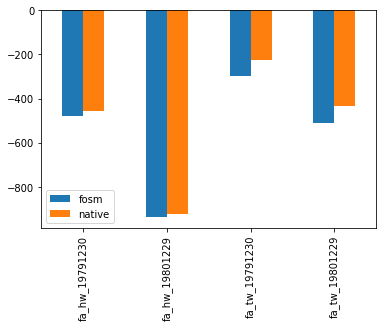

In [24]:
ax = pd.DataFrame({"native":pst.res.modelled,"fosm":res_df.modelled}).loc[pst.nnz_obs_names].plot(kind="bar")
plt.show()

### Opt under uncertainty part 2: ensemble-based chance constraints

PESTPP-OPT can also skip the FOSM calculations if users specify model-based constraint weights as standard deviations (e.g. uncertainty in the forecasts/constraints).  These can be derived from existing ensembles (oh snap!)

In [25]:
obs_df = pd.read_csv(os.path.join("master_prior_sweep","sweep_out.csv"),index_col=0)
obs_df = obs_df.loc[obs_df.failed_flag==0,:]

In [26]:
pr_std = obs_df.std().loc[pst.nnz_obs_names]
pr_std

fa_hw_19791230     670.687885
fa_hw_19801229    1152.799411
fa_tw_19791230     762.612351
fa_tw_19801229    1111.912658
dtype: float64

In [27]:
pst.observation_data.loc[pst.nnz_obs_names,"weight"] = pr_std.loc[pst.nnz_obs_names]
pst.pestpp_options["opt_std_weights"] = True
pst.write(os.path.join(t_d,"freyberg_opt_uu2.pst"))

noptmax:1, npar_adj:26, nnz_obs:4


In [28]:
pyemu.os_utils.start_slaves(t_d,"pestpp-opt","freyberg_opt_uu2.pst",num_slaves=num_workers,master_dir=m_d)

In [29]:
par_df = pyemu.pst_utils.read_parfile(os.path.join(m_d,"freyberg_opt_uu2.1.par"))
print(par_df.loc[dvg_pars,"parval1"].sum())
par_df.loc[dvg_pars,:]

13.95025426349175


,parnme,parval1,scale,offset
parnme,,,,
wf0200090016,wf0200090016,3.000000,1.0,0.0
wf0200110013,wf0200110013,3.000000,1.0,0.0
wf0200200014,wf0200200014,0.000000,1.0,0.0
wf0200260010,wf0200260010,1.950254,1.0,0.0
wf0200290006,wf0200290006,3.000000,1.0,0.0
wf0200340012,wf0200340012,3.000000,1.0,0.0


Why is the objective function higher when we use the ensemble-based constraint uncertainty compared to the FOSM constraint uncertainty?  remember how many more parameters were used in the ensemble analyses compared to just the hand full of constant by layer parameters???

### Super secret mode for `LP`

It turns out, if the opt problem is truely linear, we can reuse results of a previous PESTPP-OPT run to modify lots of the pieces of the optimization problem and resolve the optimization problem without running the model even once!  WAT!? 

As long as the same decision variables are relates to the same responses, and we can fairly assume that the response matrix that relates the decision variables to the constraints is linear, then the response matrix doesn't change even if things like bounds and risk level change. We just need `pestpp-opt` to read in the response matrix (which is stored with the same format as a Jacobian (`jcb`)) and the residuals (`rei`). 

This is done by specifying some additional `++args` (and copying some files around)

In [30]:
shutil.copy2(os.path.join(m_d,"freyberg_opt_uu2.1.jcb"),os.path.join(m_d,"restart.jcb"))
shutil.copy2(os.path.join(m_d,"freyberg_opt_uu2.1.jcb.rei"),os.path.join(m_d,"restart.rei"))

'master_opt/restart.rei'

Once we have copied over the necessary files, we set a few `++args`:  
* `base_jacobian`: this instructs `pestpp-opt` to read in the existing response matrix
* `hotstart_resfile`: this instructs `pestpp-opt` to use the residuals we already have
* `opt_skip_final`: this waives the usual practice of running the model once with optimal parameter values

In [31]:
pst.pestpp_options["base_jacobian"] = "restart.jcb"
pst.pestpp_options["hotstart_resfile"] = "restart.rei"
pst.pestpp_options["opt_skip_final"] = True
pst.write(os.path.join(m_d,"freyberg_opt_restart.pst"))

noptmax:1, npar_adj:26, nnz_obs:4


In [32]:
pyemu.os_utils.run("pestpp-opt freyberg_opt_restart.pst",cwd=m_d)

In [33]:
par_df = pyemu.pst_utils.read_parfile(os.path.join(m_d,"freyberg_opt_restart.1.par"))
print(par_df.loc[dvg_pars,"parval1"].sum())
par_df.loc[dvg_pars,:]

13.95025426349175


,parnme,parval1,scale,offset
parnme,,,,
wf0200090016,wf0200090016,3.000000,1.0,0.0
wf0200110013,wf0200110013,3.000000,1.0,0.0
wf0200200014,wf0200200014,0.000000,1.0,0.0
wf0200260010,wf0200260010,1.950254,1.0,0.0
wf0200290006,wf0200290006,3.000000,1.0,0.0
wf0200340012,wf0200340012,3.000000,1.0,0.0


Oh snap!  that means we can do all sort of kewl optimization testing really really fast...we can test a (slightly) risk averse stance too:

In [34]:
pst.pestpp_options["opt_risk"] = 0.51
pst.write(os.path.join(m_d,"freyberg_opt_restart.pst"))
pyemu.os_utils.run("pestpp-opt freyberg_opt_restart.pst",cwd=m_d)
par_df = pyemu.pst_utils.read_parfile(os.path.join(m_d,"freyberg_opt_restart.1.par"))
print(par_df.loc[dvg_pars,"parval1"].sum())
par_df.loc[dvg_pars,:]

noptmax:1, npar_adj:26, nnz_obs:4
11.61331368446538


,parnme,parval1,scale,offset
parnme,,,,
wf0200090016,wf0200090016,3.000000,1.0,0.0
wf0200110013,wf0200110013,3.000000,1.0,0.0
wf0200200014,wf0200200014,0.000000,1.0,0.0
wf0200260010,wf0200260010,0.000000,1.0,0.0
wf0200290006,wf0200290006,3.000000,1.0,0.0
wf0200340012,wf0200340012,2.613314,1.0,0.0


Lets use the functionality to evaluate how our OUU problem changes if we use posterior standard deviations - this is a critically important use of the uncertainty analysis from history matching:

In [35]:
obs_df = pd.read_csv(os.path.join("master_ies","freyberg_ies.3.obs.csv"),index_col=0)

#df = df=pd.read_csv(os.path.join("master_glm","freyberg_pp.post.obsen.csv"),index_col=0)
#obs_df = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)
#obs_df = obs_df.loc[obs_df.phi_vector.sort_values().index[:20],:] 
pt_std = obs_df.std().loc[pst.nnz_obs_names]
obs_df.std().loc[pst.nnz_obs_names]
#obs_df.max().loc[pst.nnz_obs_names]

fa_hw_19791230    231.964078
fa_hw_19801229    653.644777
fa_tw_19791230    203.515236
fa_tw_19801229    424.072213
dtype: float64

How much lower is the posterior standard deviations as compared to the prior?

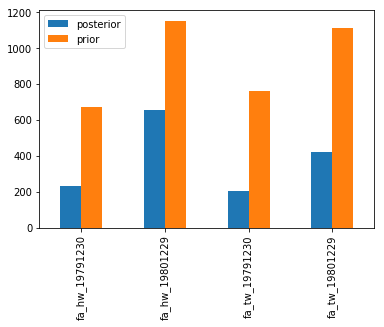

In [36]:
pd.DataFrame({"prior":pr_std,"posterior":pt_std}).plot(kind="bar")

This implies that the chance constraints (which express the important model input uncertainty propogated to the forecast/constraints) is significantly lower, meaning uncertainty has less "value" in the optimization objective function

In [37]:
pst.observation_data.loc[pst.nnz_obs_names,"weight"] = pt_std.loc[pst.nnz_obs_names]
pst.observation_data.loc[pst.nnz_obs_names,"weight"]

obsnme
fa_hw_19791230    231.964078
fa_hw_19801229    653.644777
fa_tw_19791230    203.515236
fa_tw_19801229    424.072213
Name: weight, dtype: float64

In [38]:
pst.write(os.path.join(m_d,"freyberg_opt_restart.pst"))
pyemu.os_utils.run("pestpp-opt freyberg_opt_restart.pst",cwd=m_d)
par_df = pyemu.pst_utils.read_parfile(os.path.join(m_d,"freyberg_opt_restart.1.par"))
print(par_df.loc[dvg_pars,"parval1"].sum())
par_df.loc[dvg_pars,:]

noptmax:1, npar_adj:26, nnz_obs:4
11.782262423440297


,parnme,parval1,scale,offset
parnme,,,,
wf0200090016,wf0200090016,3.000000,1.0,0.0
wf0200110013,wf0200110013,3.000000,1.0,0.0
wf0200200014,wf0200200014,0.000000,1.0,0.0
wf0200260010,wf0200260010,0.000000,1.0,0.0
wf0200290006,wf0200290006,3.000000,1.0,0.0
wf0200340012,wf0200340012,2.782262,1.0,0.0


In [39]:
pyemu.pst_utils.read_resfile(os.path.join(m_d,"freyberg_opt_restart.1.est+fosm.rei")).loc[pst.nnz_obs_names,:]

,name,group,measured,modelled,residual,weight
name,,,,,,
fa_hw_19791230,fa_hw_19791230,less_than,-300.0,-466.987924,1.669879e+02,231.964078
fa_hw_19801229,fa_hw_19801229,less_than,-300.0,-915.466742,6.154667e+02,653.644777
fa_tw_19791230,fa_tw_19791230,less_than,-300.0,-300.000000,5.684342e-14,203.515236
fa_tw_19801229,fa_tw_19801229,less_than,-300.0,-445.500643,1.455006e+02,424.072213


Again we see that scenarion tail water flux is the binding constraint.  So!  Lets reformulate the problem to be constrained by the total sw-gw flux across all reaches instead of splitting into headwaters and tailwaters.  Good thing we have added the list file budget components to the control file!

In [40]:
pst = pyemu.Pst(os.path.join(m_d,"freyberg_opt_restart.pst"))
obs = pst.observation_data
obs.loc[pst.nnz_obs_names,"obgnme"] = "sw-gw"
obs.loc[pst.nnz_obs_names,"weight"] = 0.0

In [41]:
tot_swgw = obs.loc[obs.obgnme=="flx_stream_","obsnme"]

In [42]:
obs.loc[tot_swgw,"obgnme"] = "less_than"
obs.loc[tot_swgw,"weight"] = 1.0
obs.loc[tot_swgw,"weight"] = obs_df.std().loc[pst.nnz_obs_names]
obs.loc[tot_swgw,"obsval"] = -600


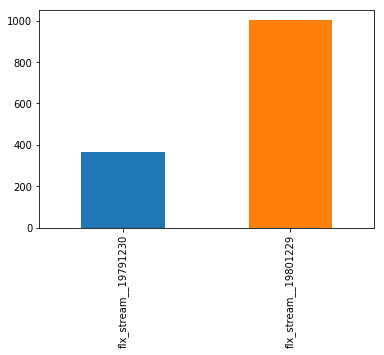

In [43]:
obs_df.std().loc[pst.nnz_obs_names].plot(kind="bar")

Since we want to find the most risk averse stance that is still feasible we will run a sweep of risk values:

In [44]:
par_dfs = []
res_dfs = []
risk_vals = np.arange(0.05,1.0,0.05)
for risk in risk_vals:
    #try:
    #    os.remove(os.path.join(m_d,"freyberg_opt_restart.1.est+fosm.rei"))
    #except:
    #    pass
   
    pst.pestpp_options["opt_risk"] = risk
    pst.pestpp_options["opt_skip_final"] = True
    pst.write(os.path.join(m_d,"freyberg_opt_restart.pst"))
    pyemu.os_utils.run("pestpp-opt freyberg_opt_restart.pst",cwd=m_d)
    par_df = pyemu.pst_utils.read_parfile(os.path.join(m_d,"freyberg_opt_restart.1.par"))
    par_df = par_df.loc[dvg_pars,:]
    #when the solution is infeasible, pestpp-opt writes extreme negative values 
    # to the par file:
    if par_df.parval1.sum() < 6.0: 
        print("infeasible at risk",risk)
        break
    res_df = pyemu.pst_utils.read_resfile(os.path.join(m_d,"freyberg_opt_restart.1.est+fosm.rei"))
    res_df = res_df.loc[pst.nnz_obs_names,:]
    res_dfs.append(res_df.modelled)
    par_dfs.append(par_df.parval1)

# process the dec var and constraint dataframes for plotting
risk_vals = risk_vals[:len(par_dfs)]
par_df = pd.concat(par_dfs,axis=1).T
par_df.index = risk_vals
par_df.index = par_df.index.map(lambda x: "{0:0.3f}".format(x))
res_df = pd.concat(res_dfs,axis=1).T
res_df.index = risk_vals
res_df.index = res_df.index.map(lambda x: "{0:0.3f}".format(x))


noptmax:1, npar_adj:26, nnz_obs:2
noptmax:1, npar_adj:26, nnz_obs:2
noptmax:1, npar_adj:26, nnz_obs:2
noptmax:1, npar_adj:26, nnz_obs:2
noptmax:1, npar_adj:26, nnz_obs:2
noptmax:1, npar_adj:26, nnz_obs:2
noptmax:1, npar_adj:26, nnz_obs:2
noptmax:1, npar_adj:26, nnz_obs:2
noptmax:1, npar_adj:26, nnz_obs:2
noptmax:1, npar_adj:26, nnz_obs:2
noptmax:1, npar_adj:26, nnz_obs:2
noptmax:1, npar_adj:26, nnz_obs:2
noptmax:1, npar_adj:26, nnz_obs:2
noptmax:1, npar_adj:26, nnz_obs:2
noptmax:1, npar_adj:26, nnz_obs:2
noptmax:1, npar_adj:26, nnz_obs:2
noptmax:1, npar_adj:26, nnz_obs:2
infeasible at risk 0.8500000000000001


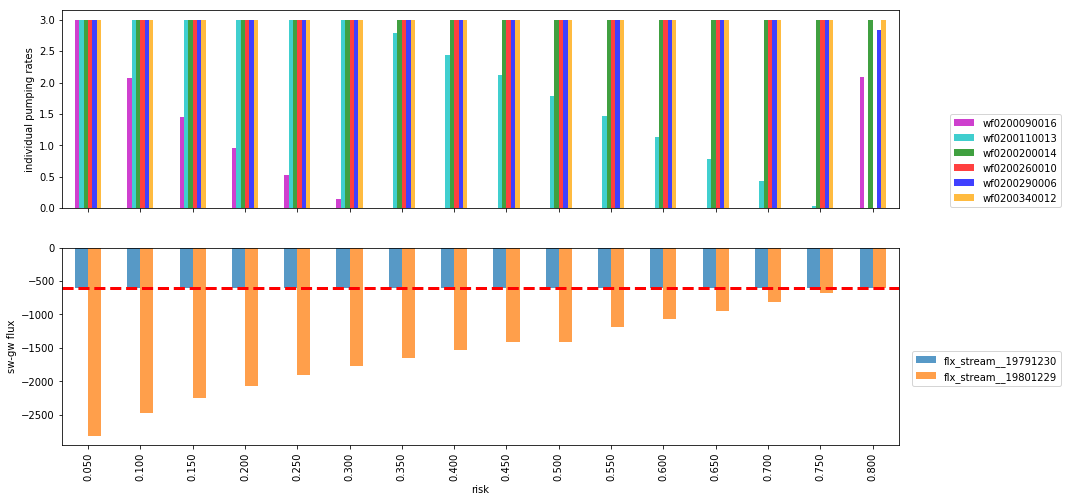

In [45]:
colors = ["m","c","g","r","b","orange"]
fig, axes = plt.subplots(2,1,figsize=(15,8))
par_df.plot(kind="bar",ax=axes[0],alpha=0.75,color=colors).legend(bbox_to_anchor=(1.2, 0.5))
axes[0].set_ylabel("individual pumping rates")
axes[0].set_xticklabels([])
res_df.plot(kind="bar",ax=axes[1],alpha=0.75).legend(bbox_to_anchor=(1.2, 0.5))
axes[1].plot(axes[1].get_xlim(),[-600,-600],"r--",lw=3)
axes[1].set_ylabel("sw-gw flux")
axes[1].set_xlabel("risk");

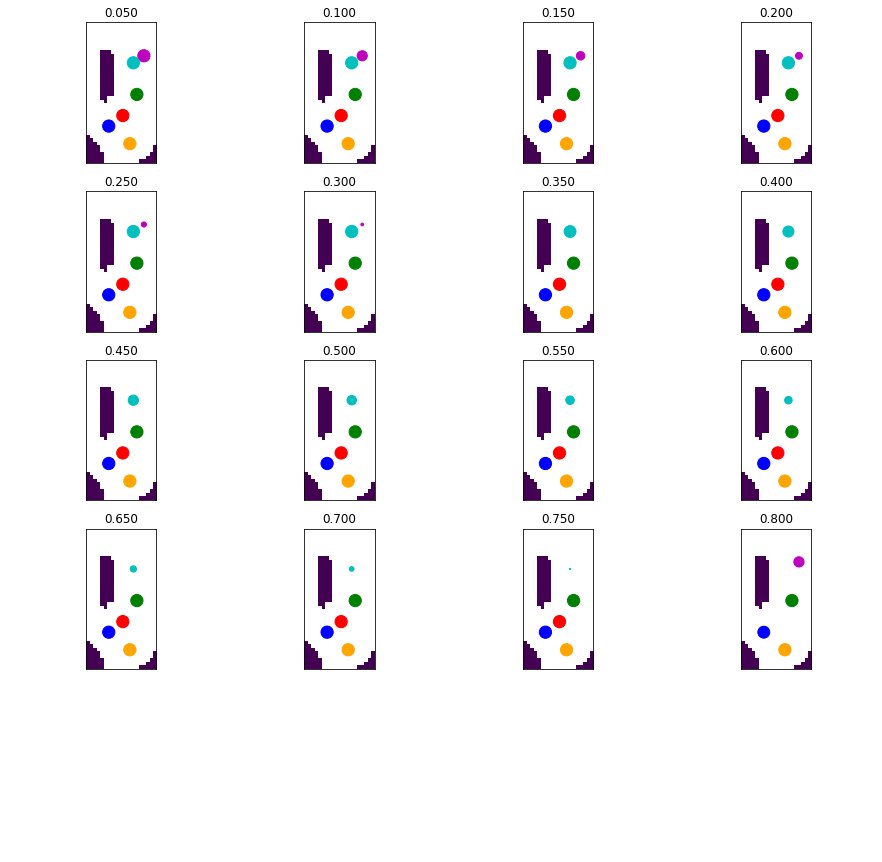

In [46]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=t_d)
wf_par = pst.parameter_data.loc[dvg_pars,:].copy()
wf_par.loc[:,"k"] = wf_par.parnme.apply(lambda x: int(x[2:4]))
wf_par.loc[:,"i"] = wf_par.parnme.apply(lambda x: int(x[4:8]))
wf_par.loc[:,"j"] = wf_par.parnme.apply(lambda x: int(x[8:]))
wf_par.loc[:,"x"] = wf_par.apply(lambda x: m.sr.xcentergrid[x.i,x.j],axis=1)
wf_par.loc[:,"y"] = wf_par.apply(lambda x: m.sr.ycentergrid[x.i,x.j],axis=1)

ib = m.bas6.ibound[0].array
ib = np.ma.masked_where(ib!=0,ib)
fig,axes = plt.subplots(5,int(np.ceil(par_df.shape[0]/5)),figsize=(15,15))
axes = axes.flatten()
for risk,ax in zip(par_df.index,axes):
    ax.set_aspect("equal")
    #ax = plt.subplot(111,aspect="equal") 
    ax.imshow(ib,extent=m.sr.get_extent())
    ax.scatter(wf_par.x,wf_par.y,s=par_df.loc[risk,wf_par.parnme].values*50,c=colors)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(risk)
    
for i in range(par_df.shape[0],axes.shape[0]):
    ax = axes[i]
    ax.axis("off")

    

how about those figures!!!

How slick was that!  no more model runs needed and yet we transformed the OUU problem (by swapping constraints) and solved for a much more risk averse stance!  Just to make sure, lets run the model with the most risk-averse decision variables:

In [47]:
pst.pestpp_options["opt_risk"] = risk_vals[-1]
pst.pestpp_options["opt_skip_final"] = False
pst.write(os.path.join(m_d,"freyberg_opt_restart.pst"))
pyemu.os_utils.run("pestpp-opt freyberg_opt_restart.pst",cwd=m_d)
# load the simulated outputs plus the FOSM chance constraint offsets:
res_df = pyemu.pst_utils.read_resfile(os.path.join(m_d,"freyberg_opt_restart.1.sim+fosm.rei"))
res_df = res_df.loc[pst.nnz_obs_names,:]
res_df

noptmax:1, npar_adj:26, nnz_obs:2


,name,group,measured,modelled,residual,weight
name,,,,,,
flx_stream__19791230,flx_stream__19791230,less_than,-600.0,-599.650785,-0.349215,365.750858
flx_stream__19801229,flx_stream__19801229,less_than,-600.0,-599.326861,-0.673139,1000.999505


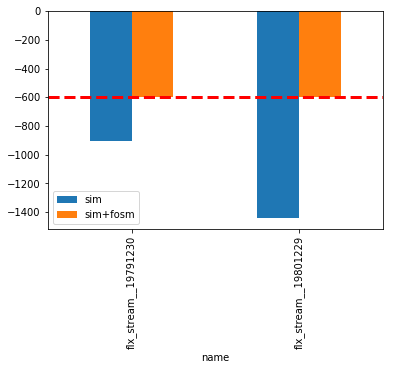

In [48]:
# load the actual model simulated outputs
res_df_sim = pyemu.pst_utils.read_resfile(os.path.join(m_d,"freyberg_opt_restart.1.sim.rei"))
res_df_sim = res_df_sim.loc[pst.nnz_obs_names,:]
ax = pd.DataFrame({"sim":res_df_sim.modelled,"sim+fosm":res_df.modelled}).plot(kind="bar")
ax.plot(ax.get_xlim(),[-600,-600],"r--",lw=3)

Here we can see the cost of uncertainty - we have to simulate a greater flux from gw to sw to make sure (e.g. be risk averse) that the flux from  gw to sw is actually at least 600 m3/day

# FINALLY!!!

We now see the reason for high-dimensional uncertainty quantification and history matching: to define and then reduce (through data assimulation) the uncertainty in the model-based constraints (e.g. sw-gw forecasts) so that we can find a more risk-averse management solution - we can use to model to identify an optimal pumping scheme to provide the volume of water needed for supply/ag but also provide assurances (at the given confidence) that ecological flows will be maintained under both current conditions and in the event of an extreme 1-year drought.  BOOM!